![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier

In [9]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [10]:
# Celda 1.1
print(bikes.groupby('season').total.mean())
print("\n")
print(bikes.groupby('season').total.min())
print("\n")
print(bikes.groupby('season').total.max())

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64


season
1    1
2    1
3    1
4    1
Name: total, dtype: int64


season
1    801
2    873
3    977
4    948
Name: total, dtype: int64


**Análisis Descriptivo Celda 1.1 Variable Season**

La variable predictora Season es categórica y posee 4 categorias, una por cada una de las estaciones del año (1:Invierno, 2:Primavera, 3:Verano, 4:Otoño).

*   Para cuando la estación corresponde al invierno (Season = 1) tenemos que el número de bicicletas promedio que se rentan es 116 apróximadamente.
*   Para cuando la estación corresponde a la primavera (Season = 2) tenemos que el número de bicicletas promedio que se rentan es 215 apróximadamente.
*   Para cuando la estación corresponde al verano (Season = 3) tenemos que el número de bicicletas promedio que se rentan es 234 apróximadamente.
*   Para cuando la estación corresponde al otoño (Season = 4) tenemos que el número de bicicletas promedio que se rentan es 198 apróximadamente.

Adicionalmente, tenemos que el mínimo de bicicletas que se prestan en cualquier estación del año es de 1. Sin embargo, cuando es invierno se han prestado hasta 801, cuando es primavera hasta 873, cuando es verano hasta 977, y finalmente, cuando la estación es otoño se han llegado a prestar hasta 948 bicicletas.

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64




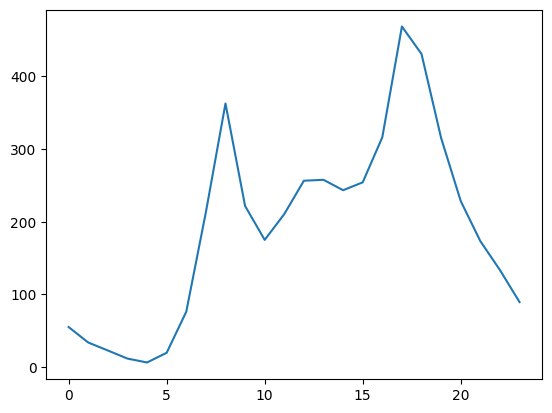

In [11]:
# Celda 1.2
print(bikes.groupby('hour').total.mean())
print("\n")
print(plt.plot(bikes.groupby('hour').total.mean()))

**Análisis Descriptivo Celda 1.2 Variable Hour**

La variable predictora Hour es categórica y posee 24 categorias, correspondientes a las horas del día.

*   La hora que menos demanda de bicicletas tiene es 4:00 AM donde 6 bicicletas en promedio se rentan a esta hora.
*   La hora que más demanda de bicicletas tiene es 5:00 PM donde 468 bicicletas en promedio se rentan a esta hora.

Al graficar el dataset podemos ver el comportamiento de las bicicletas rentadas durante el día, el eje x corresponde a la hora del día y el eje y al número de bicicletas rentadas. El rango horario donde mas se rentan bicicletas es de 7:AM a 10:00 PM

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

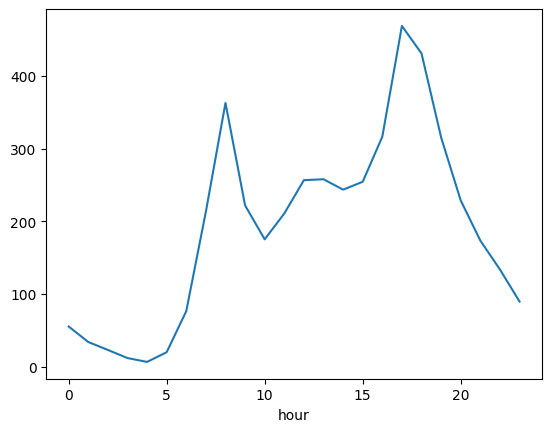

In [12]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

Axes(0.125,0.11;0.775x0.77)


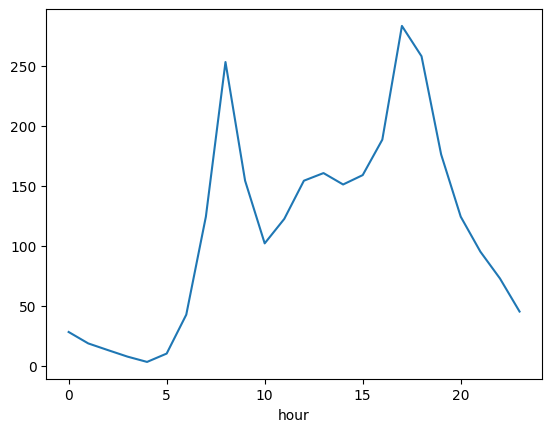

In [14]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos
season_1 = bikes[bikes.season == 1].groupby('hour').total.mean().plot()
print(season_1)

**Análisis Celda 2.2 Variable Season = 1 (Invierno)**

Podemos ver que el comportamiento de la renta de bicicletas durante el día cambia dependiendo de la estación del año. La gráfica nos muestra que cuando la estación es invierno, el comportamiento de la renta de bicicletas es similar al comportamiento base. Es evidente que se maneja el mismo patrón en las diferentes horas del día, al igual que las mismas horas pico de renta de bicicletas. Sin embargo, es posible evidenciar que en invierno el número de bicicletas rentadas disminuye en casi un 50%. Esto tiene sentido debido a las temperaturas que se alcanzan normalmente en esta época del año, las cuales no son óptimas o no muy cómodas para andar en bicicleta.

Axes(0.125,0.11;0.775x0.77)


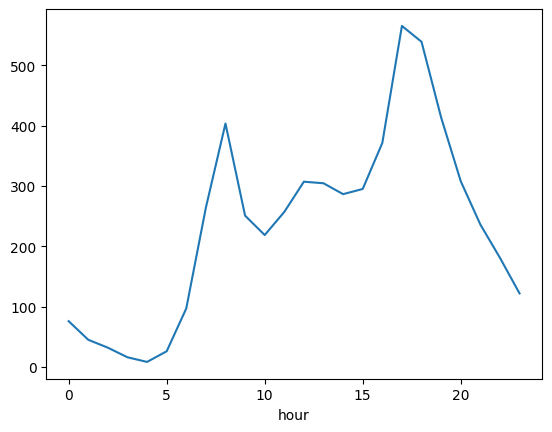

In [15]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos
season_3 = bikes[bikes.season == 3].groupby('hour').total.mean().plot()
print(season_3)

**Análisis Celda 2.3 Variable Season = 3 (Verano)**

Podemos ver que el comportamiento de la renta de bicicletas durante el día cambia dependiendo de la estación del año. La gráfica nos muestra que cuando la estación es verano, el comportamiento de la renta de bicicletas es similar al comportamiento base, incluso similar a cuando la estación es invierno. Es evidente que se maneja el mismo patrón en las diferentes horas del día, al igual que las mismas horas pico de renta de bicicletas. Sin embargo, es posible evidenciar que en verano el número de bicicletas rentadas aumenta sutilmente superando las 500 bicicletas rentadas. Esto tiene sentido debido a las temperaturas que se alcanzan normalmente en esta época del año, las cuales son óptimas y más adecuadas para andar en bicicleta.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [16]:
# Celda 3
y_train = bikes["total"]
bikes['hour'] = pd.factorize(bikes.hour)[0]
bikes['season'] = pd.factorize(bikes.season)[0]
X_train = pd.concat([bikes['hour'], bikes['season']], axis=1)

linearR = LinearRegression().fit(X_train, y_train)
print("B0: " + str(linearR.intercept_))
print("Betas: "+ str(linearR.coef_))

B0: 29.536159845355144
Betas: [10.52129824 26.95130851]


**Análisis Celda 3 Modelo de Regresión Lineal (Season y Hour)**

Una vez realizado el modelo de regresión lineal obtenemos que para la variable Hour tenemos un beta de 10.52 y para la variable Season tenemos un beta de 26.95. Justamente genera ciertas dificultades realizar la interpretación de estos coeficientes debido a que son variables categoricas, por lo que esta es una de las limitaciones del modelo de regresión lineal, que no es directamente interpretable cuando se tiene una variable con varias categorías.



### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [17]:
# Celda 4
print("Primera ramificación")

# Impresión variable a usar (Season)
print(X_train.columns[1])
# División de la variable Season
filter_l = X_train.iloc[:, 1] == 1
# División de la variable de respuesta de acuerdo a si la observación cumple o no con la regla binaria
y_l = y_train.loc[filter_l] # y_l: la observación es en invierno
y_r = y_train.loc[~filter_l] # y_r: la observación NO es en invierno.
predict_l = np.average(y_l) # Prediccion de la particion l
predict_r = np.average(y_r) # Predicción de la partición r
MSE_l = np.average( np.square(predict_l - y_l) )
MSE_r = np.average( np.square(predict_r - y_r) )
print("MSE (Season = 1) : "+str(MSE_l))
print("MSE (Season != 1) : "+str(MSE_r))
print("")

# Impresión variable a usar (Hour)
print(X_train.columns[0])
# División de la variable Hour
filter_2 = X_train.iloc[:, 0] > 7

y_l = y_train.loc[filter_2] # y_l: la observación es despues de las 7 AM.
y_r = y_train.loc[~filter_2] # y_l: la observación es antes de las 7 AM.
predict_l = np.average(y_l)
predict_r = np.average(y_r)
MSE_l = np.average( np.square(predict_l - y_l) )
MSE_r = np.average( np.square(predict_r - y_r) )

print("MSE (Hour > 7) : " + str(MSE_l))
print("MSE (Hour < 7) : " + str(MSE_r))
print("")
print("Seleccion primer Nodo -> Hour < 7")
print('\n')

print("Segunda ramificación (Hour < 7)")
## Explorar el nodo Hour < 7
filter_3 = (X_train.iloc[:, 0] < 7) & (X_train.iloc[:, 1] == 3) #Nodo Hour < 7 y Season = 3
filter_4 = (X_train.iloc[:, 0] < 7) & (X_train.iloc[:, 1] != 3) #Nodo Hour < 7 y Season != 3
y_l = y_train.loc[filter_3] # y_l: la observación es antes de las 7 AM y es en verano.
y_r = y_train.loc[filter_4] # y_l: la observación es antes de las 7 AM y NO es en verano.
predict_l, predict_r = np.average(y_l), np.average(y_r)
MSE_l = np.average( np.square(predict_l - y_l) )
MSE_r = np.average( np.square(predict_r - y_r) )
print("NODO FINAL - MSE (Hour < 7) & (Season = 3): " + str(MSE_l))
print("NODO FINAL - MSE (Hour < 7) & (Season != 3): " + str(MSE_r))

print('\n')
print("Tercera ramificación (Hour > 22)")
## Explorar el nodo Hour < 7
filter_5 = (X_train.iloc[:, 0] > 22) & (X_train.iloc[:, 0] < 7) #Nodo 22 < Hour < 7
filter_6 = (X_train.iloc[:, 0] >= 7) & (X_train.iloc[:, 0] < 24) #Nodo 7 < Hour < 21

y_l = y_train.loc[filter_5] # y_l: la observación es entre las 10 PM y las 7 AM.
y_r = y_train.loc[filter_6] # y_l: la observación es entre las 7 AM y las 9 PM.
predict_l, predict_r = np.average(y_l), np.average(y_r)
MSE_l = np.average( np.square(predict_l - y_l) )
MSE_r = np.average( np.square(predict_r - y_r) )
print("MSE (22 < Hour < 7): " + str(MSE_l))
print("MSE (7 < Hour < 21): " + str(MSE_r))
print("")
print("Seleccion tercer Nodo -> 22 < Hour < 7")
print('\n')
print("Cuarta ramificación (22 < Hour < 7) ")
filter_7 = (X_train.iloc[:, 0] > 22) & (X_train.iloc[:, 0] < 7) & (X_train.iloc[:, 1] == 2) #Nodo 22 < Hour < 7 y es en primavera.
filter_8 = (X_train.iloc[:, 0] > 22) & (X_train.iloc[:, 0] < 7) & (X_train.iloc[:, 1] != 2) #Nodo 22 < Hour < 7 y NO es en primavera.
y_l = y_train.loc[filter_7] # y_l: la observación es entre 10 PM y 7 AM y es en primavera.
y_r = y_train.loc[filter_8] # y_l: la observación es es entre 10 PM y 7 AM y NO es en primavera.
predict_l, predict_r = np.average(y_l), np.average(y_r)
MSE_l = np.average( np.square(predict_l - y_l) )
MSE_r = np.average( np.square(predict_r - y_r) )
print("NODO FINAL - MSE (22 < Hour < 7) & (Season = 2): " + str(MSE_l))
print("NODO FINAL - MSE (22 < Hour < 7) & (Season != 2): " + str(MSE_r))

print('\n')
print("Quinta ramificación (Hour >= 7)")
filter_9 = (X_train.iloc[:, 0] >= 7) & (X_train.iloc[:, 1] == 4) #Nodo Hour > 7 y es en otoño.
filter_10 = (X_train.iloc[:, 0] >= 7) & (X_train.iloc[:, 1] != 4) #Nodo Hour > 7 y NO es en otoño.
y_l = y_train.loc[filter_9] # y_l: la observación es despues de 7 AM y es en otoño..
y_r = y_train.loc[filter_10] # y_l: la observación es despues de 7 AM y NO es en otoño.
predict_l, predict_r = np.average(y_l), np.average(y_r)
MSE_l = np.average( np.square(predict_l - y_l) )
MSE_r = np.average( np.square(predict_r - y_r) )
print("NODO FINAL - MSE (Hour >= 7) & (Season = 4): " + str(MSE_l))
print("NODO FINAL - MSE (Hour >= 7) & (Season != 4): " + str(MSE_r))

Primera ramificación
season
MSE (Season = 1) : 36853.522249306465
MSE (Season != 1) : 31204.03370592009

hour
MSE (Hour > 7) : 31316.752383585103
MSE (Hour < 7) : 8173.069710337732

Seleccion primer Nodo -> Hour < 7


Segunda ramificación (Hour < 7)
NODO FINAL - MSE (Hour < 7) & (Season = 3): 1608.816625527133
NODO FINAL - MSE (Hour < 7) & (Season != 3): 1549.515144957355


Tercera ramificación (Hour > 22)
MSE (22 < Hour < 7): nan
MSE (7 < Hour < 21): 31077.582402988504

Seleccion tercer Nodo -> 22 < Hour < 7


Cuarta ramificación (22 < Hour < 7) 
NODO FINAL - MSE (22 < Hour < 7) & (Season = 2): nan
NODO FINAL - MSE (22 < Hour < 7) & (Season != 2): nan


Quinta ramificación (Hour >= 7)
NODO FINAL - MSE (Hour >= 7) & (Season = 4): nan
NODO FINAL - MSE (Hour >= 7) & (Season != 4): 31077.582402988504


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

Calibracion del párametro max_depth


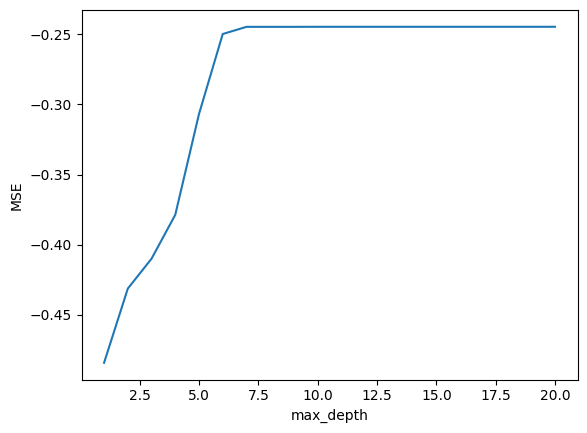

(-0.4841374721061996, 1)

In [19]:
# Celda 5
# Definir matriz X y Y para entrenar los modelos
y_train = bikes["total"]
bikes['hour'] = pd.factorize(bikes.hour)[0]
bikes['season'] = pd.factorize(bikes.workingday)[0]
X_train = pd.concat([bikes['hour'], bikes['season']], axis=1)

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del MSE para cada valor de máxima profundidad (max_depth)
mse_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    mse_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring=None).mean())

print("Calibracion del párametro max_depth")
# Gráfica max_depth versus MSE (error del modelo)
plt.plot(max_depth_range, mse_scores)
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.show()

# Mejor MSE (desempeño del modelo) y su correspondiente max_depth
sorted(zip(mse_scores, max_depth_range), reverse = True)[::-1][0]

**Análisis Celda 5 Árbol de Decisión con Librería**

En primer lugar cabe aclarar que se está usando el mismo conjunto de entrenamiento para calibrar un parámetro del modelo, por lo tanto, se espera que el comportamiento del MSE no sea cóncavo, es decir, no funciona para calibrar. Sin embargo, hacemos la calibración a pesar de lo anterior y obtenemos que la profundidad que minimiza el MSE es igual a 1, con un MSE de -0.48

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [20]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [21]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [22]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

Estimando Modelo de Regresión logística
Modelo estimado

El Acurracy del modelo de regresión logística es 0.6253333333333333
El F1-Score para el modelo de regresión logística es 0.6129476584022039


Estimando Modelo de Árbol
Modelo estimado

Calibracion del parametro max_depth para el modelo de Árbol


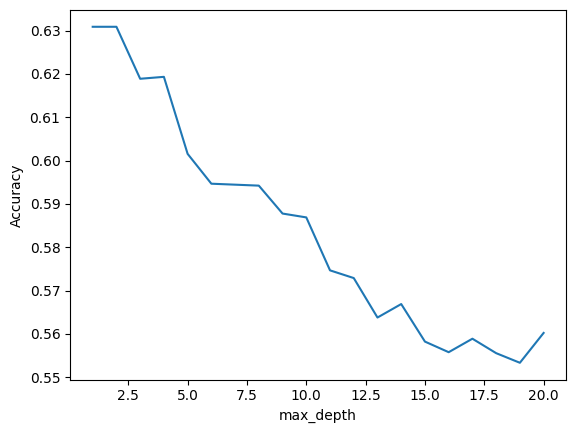

La maxima profundidad del arbol que tiene el mayor Accuracy es: 2

El Acurracy del árbol calibrado es 0.6308888888888888

El F1-Score para el modelo de árbol es 0.6448598130841121


In [24]:
# Celda 6
# Regresión logistica
print("Estimando Modelo de Regresión logística")

clfRegLog= LogisticRegression(random_state=0,max_iter=10000) # Generar un modelo
clfRegLog.fit(X_train,y_train) #Estimar el modelo
y_predReglog = clfRegLog.predict(X_test) #Predecir con el modelo de regresion logistica
print("Modelo estimado")
print("")
print("El Acurracy del modelo de regresión logística es " +  str(metrics.accuracy_score(y_predReglog, y_test)))
print("El F1-Score para el modelo de regresión logística es "+ str(metrics.f1_score(y_predReglog, y_test)))
print("\n")

##  Tree
max_depth_range = range(1, 21) #Rango de calibracion
accuracy_scores = []
print("Estimando Modelo de Árbol")
# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring="accuracy").mean())
print("Modelo estimado")
print("")
print("Calibracion del parametro max_depth para el modelo de Árbol")
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
print("La maxima profundidad del arbol que tiene el mayor Accuracy es: " +  str(sorted(zip(accuracy_scores, max_depth_range))[::-1][0][1]))
print("")
print("El Acurracy del árbol calibrado es " +  str(sorted(zip(accuracy_scores, max_depth_range))[::-1][0][0]))
print("")
#Predecir la variable y con el arbol de desicion calibrado
y_predTree = DecisionTreeClassifier(max_depth= sorted(zip(accuracy_scores, max_depth_range))[::-1][0][1] , random_state=1).fit(X, y).predict(X_test)
print("El F1-Score para el modelo de árbol es "+ str(metrics.f1_score(y_predTree, y_test)))

**Análisis Celda 6 Árbol de Decisión y Regresión Logística**

Se estimaron 2 modelos de clasificación, en primer lugar, se realizó un modelo de regresión logística y posteriormente se estimó un modelo de árbol de decisión.

Para el modelo de regresión logística tenemos que sus medidas de desempeño son:

*   Acurracy: 0.625
*   F1-Score: 0.612

Por otro lado, para el modelo árbol de decisión calibrado en una maxima profundidad de 2 tenemos que sus medidas de desempeño son:

*   Acurracy: 0.630
*   F1-Score: 0.644

A partir de estos resultados se puede concluir que para este caso en particular el modelo de árbol de decisión tiene mejor desempeño predictivo que la regresión logística según las métricas Acurracy y F1-Score.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados.

Nota:

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [27]:
# Celda 7
# Uso de BaggingRegressor de la libreria (sklearn) para estimar los diferentes modelos.
bagg100TreeDepthNone = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth=None), n_estimators = 100,
                          bootstrap=True, oob_score=True , max_samples = 300, random_state=1,n_jobs=-1)

bagg100TreeLeaf10 = BaggingClassifier(DecisionTreeClassifier(min_samples_leaf=10), n_estimators = 100,
                          bootstrap=True, oob_score=True , max_samples = 300, random_state=1,n_jobs=-1)

bagg100RegLog = BaggingClassifier(LogisticRegression(random_state=1,max_iter=1000), n_estimators = 100,
                          bootstrap=True, oob_score=True , max_samples = 300, random_state=1,n_jobs=-1)

# Entrenemiento de los modelos con set de entrenamiento y predicción en el set de test
print("Entrenamos modelo Tree Depth = None")
bagg100TreeDepthNone.fit(X_train, y_train)
y_predbagg100TreeDepthNone = bagg100TreeDepthNone.predict(X_test)
print('Modelo Entrenado')
print("")
print('El F1-Score y el Acurracy del modelo bagging de Árbol con MaxDepth = None son respectivamente')
print(metrics.f1_score(y_predbagg100TreeDepthNone, y_test), metrics.accuracy_score(y_predbagg100TreeDepthNone, y_test))

print('\n')
print("Entrenamos modelo Tree Leaf = 10")
bagg100TreeLeaf10.fit(X_train, y_train)
y_predbagg100TreeLeaf10 = bagg100TreeLeaf10.predict(X_test)
print('Modelo Entrenado')
print("")
print('El F1-Score y el Acurracy del modelo bagging de Árbol con MinSamplesLeaf = 10 son respectivamente')
print(metrics.f1_score(y_predbagg100TreeLeaf10, y_test), metrics.accuracy_score(y_predbagg100TreeLeaf10, y_test))

print('\n')
print("Entrenamos modelo Reg Logística")
bagg100RegLog.fit(X_train, y_train)
y_predbagg100RegLog = bagg100RegLog.predict(X_test)
print('Modelo Entrenado')
print("")
print('El F1-Score y el Acurracy del modelo Reg Logística son respectivamente')
print(metrics.f1_score(y_predbagg100RegLog, y_test), metrics.accuracy_score(y_predbagg100RegLog, y_test))

Entrenamos modelo Tree Depth = None
Modelo Entrenado

El F1-Score y el Acurracy del modelo bagging de Árbol con MaxDepth = None son respectivamente
0.6626262626262627 0.666


Entrenamos modelo Tree Leaf = 10
Modelo Entrenado

El F1-Score y el Acurracy del modelo bagging de Árbol con MinSamplesLeaf = 10 son respectivamente
0.6653306613226453 0.666


Entrenamos modelo Reg Logística
Modelo Entrenado

El F1-Score y el Acurracy del modelo Reg Logística son respectivamente
0.6162235855487389 0.6246666666666667


**Análisis Celda 7 Votación Mayoritaria**

Se elaboro un esamble con la metodología de Votación mayoritaria compuesto por 300 muestras bagged donde:

*   Las primeras 100 muestras vienen de árboles de decisión donde max_depth = None
*   Las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf = 10
*   Las últimas 100 muestras vienen de regresiones logísticas

Para el modelo de las primeras 100 muestras vienen de árboles de decisión donde max_depth = None tenemos que sus medidas de desempeño son:

*   Acurracy: 0.66
*   F1-Score: 0.662

Para el modelo de las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf = 10 tenemos que sus medidas de desempeño son:

*   Acurracy: 0.66
*   F1-Score: 0.665

Para el modelo de Las últimas 100 muestras vienen de regresiones logísticas tenemos que sus medidas de desempeño son:

*   Acurracy: 0.61
*   F1-Score: 0.62

A partir de estos resultados se puede concluir que el modelo de de las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf = 10 tiene minimamente un mejor desempeño predictivo que los otros dos modelos según las métricas Acurracy y F1-Score.

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [30]:
# Celda 8
# Votación ponderada para el modelo bagging de Árbol con MaxDepth = None
errors = np.zeros(bagg100TreeDepthNone.n_estimators)
y_pred_all_ = np.zeros( (X_test.shape[0], bagg100TreeDepthNone.n_estimators) )
for i in range(bagg100TreeDepthNone.n_estimators):
    oob_sample = ~bagg100TreeDepthNone.estimators_samples_[i]
    y_pred_ = bagg100TreeDepthNone.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = bagg100TreeDepthNone.estimators_[i].predict(X_test)

alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(int)
# Metricas con votación ponderada
print('El F1-Score y el Acurracy del modelo bagging de Árbol con MaxDepth = None y votación ponderada son respectivamente')
print(metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test))

print('\n')
#Votación ponderada para el modelo bagging de Árbol con min_samples_leaf = 10
errors = np.zeros(bagg100TreeLeaf10.n_estimators)
y_pred_all_ = np.zeros( (X_test.shape[0], bagg100TreeLeaf10.n_estimators) )
for i in range(bagg100TreeLeaf10.n_estimators):
    oob_sample = ~bagg100TreeLeaf10.estimators_samples_[i]
    y_pred_ = bagg100TreeLeaf10.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = bagg100TreeLeaf10.estimators_[i].predict(X_test)
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(int)
# Metricas con votación ponderada
print('El F1-Score y el Acurracy del modelo bagging de Árbol con min_samples_leaf = 10 y votación ponderada son respectivamente')
print(metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test))

print('\n')
#Votación ponderada para el modelo Reg Logística
errors = np.zeros(bagg100RegLog.n_estimators)
y_pred_all_ = np.zeros( (X_test.shape[0], bagg100RegLog.n_estimators) )

for i in range(bagg100RegLog.n_estimators):
    oob_sample = ~bagg100RegLog.estimators_samples_[i]
    y_pred_ = bagg100RegLog.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = bagg100RegLog.estimators_[i].predict(X_test)
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(int)
# Metricas con votación ponderada
print('El F1-Score y el Acurracy del modelo regresión logística con votación ponderada son respectivamente')
print(metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test))

El F1-Score y el Acurracy del modelo bagging de Árbol con MaxDepth = None y votación ponderada son respectivamente
0.6640053226879573 0.6633333333333333


El F1-Score y el Acurracy del modelo bagging de Árbol con min_samples_leaf = 10 y votación ponderada son respectivamente
0.6579849211788896 0.6673333333333333


El F1-Score y el Acurracy del modelo regresión logística con votación ponderada son respectivamente
0.6141192597669637 0.6246666666666667


**Análisis Celda 8 Votación Ponderada**

Se elaboro un esamble con la metodología de Votación ponderada compuesto por 300 muestras bagged donde:

*   Las primeras 100 muestras vienen de árboles de decisión donde max_depth = None
*   Las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf = 10
*   Las últimas 100 muestras vienen de regresiones logísticas

Para el modelo de las primeras 100 muestras vienen de árboles de decisión donde max_depth = None tenemos que sus medidas de desempeño son:

*   Acurracy: 0.663
*   F1-Score: 0.664

Para el modelo de las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf = 10 tenemos que sus medidas de desempeño son:

*   Acurracy: 0.657
*   F1-Score: 0.667

Para el modelo de Las últimas 100 muestras vienen de regresiones logísticas tenemos que sus medidas de desempeño son:

*   Acurracy: 0.624
*   F1-Score: 0.614

A partir de estos resultados se puede concluir que el modelo de de las primeras 100 muestras vienen de árboles de decisión donde max_depth = None tiene un mejor desempeño predictivo que los otros dos modelos según las métricas Acurracy y F1-Score. De igual forma se observa que las métricas de los diferentes modelos son un poco más diferentes a comparación de la votación mayoritaria.

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

**Análisis Celda 9 Comparación y Análisis de Resultados**

En los puntos 7 y 8 se generaron ensamblajes con distintos tipos de clasificadores. Se utilizaron los siguientes modelos:

1. Árboles de decisión donde max_depth = None
2. Árboles de decisión donde min_samples_leaf = 10
3. Regresión logística

Para cada clasificador se generaron 300 muestras a partir de bootstrap. Finalmente, pare realizar la predicción de cada ensamblaje se propuso:

 **En el punto 7:** Las predicciones se realizaron por el método de **votación mayoritaria**, es decir, se escoge como predicción final aquella clase que tenga la mayoría de las predicciones a su favor. Esto quiere decir que se le da el mismo "peso" a todas las predicciones sin importar el error de cada modelo.

 **En el punto 8:** Las predicciones se hicieron por el método de **votación ponderada**, esto significa que la predicción final depende de una ponderación porcentual de todas las predicciones. Aquellas predicciones que aportan *más* a la predicción final son las que vienen de un modelo con error OOB bajo. De igual manera, las predicciones que *menos* aportan a la predicción final son aquellas que tiene un error OOB mayor.

Podemos ver que todas las métricas para cada uno de los 3 ensamblajes están mejorando. Es decir, **la votación ponderada es un mejor método que la votación mayoritaria**. Sin embargo, la mejora en las métricas es pequeña.